In [2]:
import os
import time
import uuid #Give unique names to each object
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [8]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read() # OpenCV reads the image in BGR format

    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg') # uuid1ame function generates a unique name for each image
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [2]:
!labelme

2024-06-12 14:22:45,046 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Isara Liyanage\.labelmerc


## 2. Review Dataset and Build Image Loading Function

In [3]:
import tensorflow as tf
import json # Labels are in jason format
import numpy as np
from matplotlib import pyplot as plt

#### Standard code to limit the gpu usage

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [52]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [53]:
images.as_numpy_iterator().next() # Checking whether the images are loaded correctly

b'data\\images\\145ea9ce-2435-11ef-9b1e-be9ffffbf19a.jpg'

In [54]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [55]:
images = images.map(load_image)

In [45]:
images.as_numpy_iterator().next()

array([[[173, 178, 172],
        [172, 177, 171],
        [173, 175, 170],
        ...,
        [116, 111, 118],
        [116, 110, 122],
        [116, 110, 122]],

       [[173, 178, 172],
        [172, 177, 171],
        [173, 175, 170],
        ...,
        [116, 111, 118],
        [116, 110, 120],
        [116, 110, 120]],

       [[175, 178, 171],
        [174, 177, 170],
        [174, 175, 169],
        ...,
        [117, 112, 119],
        [117, 112, 119],
        [116, 111, 118]],

       ...,

       [[164, 164, 166],
        [164, 164, 166],
        [164, 164, 166],
        ...,
        [137, 138, 133],
        [137, 138, 133],
        [137, 138, 133]],

       [[163, 163, 165],
        [163, 163, 165],
        [164, 164, 166],
        ...,
        [137, 138, 133],
        [136, 137, 132],
        [136, 137, 132]],

       [[163, 163, 165],
        [163, 163, 165],
        [164, 164, 166],
        ...,
        [136, 137, 132],
        [136, 137, 132],
        [136, 137, 132]]

In [56]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

#### View Raw Images

In [57]:
image_generator = images.batch(4).as_numpy_iterator()



In [60]:
plot_images = image_generator.next()

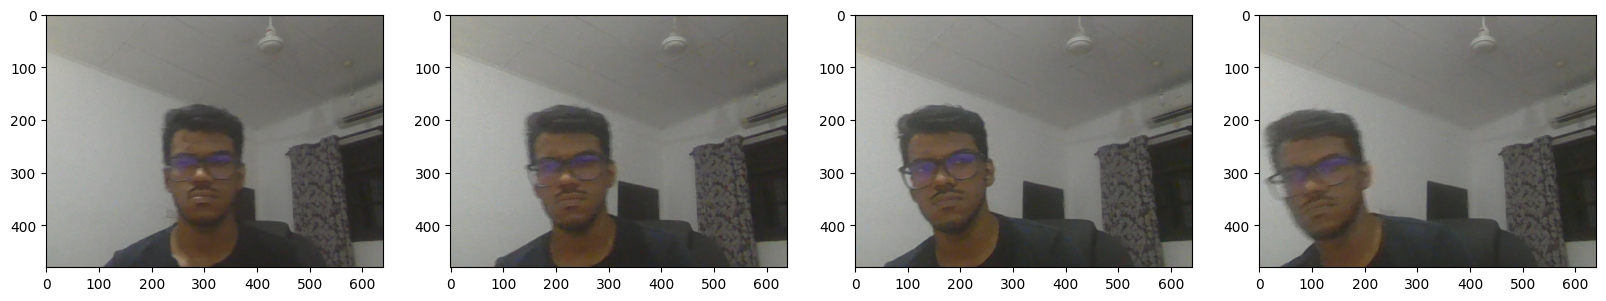

In [61]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

### Split the data


In [66]:
import os
import shutil
import random

# Paths
input_dir = 'data/images'
#output_dir = 'output'
train_dir = os.path.join('data/train', 'images')
val_dir = os.path.join('data/val', 'images')
test_dir = os.path.join('data/test', 'images')

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all image files
image_files = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

# Shuffle the image files
random.seed(1337)
random.shuffle(image_files)

# Calculate split indices
total_images = len(image_files)
train_split = int(0.7 * total_images)
val_split = int(0.85 * total_images)  # 0.7 + 0.15 = 0.85

# Split the images
train_files = image_files[:train_split]
val_files = image_files[train_split:val_split]
test_files = image_files[val_split:]

# Move images to respective directories
for file in train_files:
    shutil.move(os.path.join(input_dir, file), os.path.join(train_dir, file))

for file in val_files:
    shutil.move(os.path.join(input_dir, file), os.path.join(val_dir, file))

for file in test_files:
    shutil.move(os.path.join(input_dir, file), os.path.join(test_dir, file))

print(f'Total images: {total_images}')
print(f'Training images: {len(train_files)}')
print(f'Validation images: {len(val_files)}')
print(f'Testing images: {len(test_files)}')


Total images: 90
Training images: 62
Validation images: 14
Testing images: 14


### Moving the labels

In [67]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      